# <center> <font color='royalblue'> Project 2

**Objective:**

- Use topic modeling to decipher and identify related topics that come up in the speeches.

#### Topic Modeling

- Topic models are a suite of algorithms/statistical models that uncover the hidden/latent topics in a collection of documents.
- LDA has shown excellent results in practice and therefore has been widely adopted.

#### Usefulness of Topic Modeling
- As more information becomes available, it becomes progressively more difficult to understand the information or find what we are looking for. 
- Topic modeling: a tool to organize, understand and summarize large collections of text. Useful for:
  - Discovering hidden patterns 
  - Annotating documents according to the discovered topics
  - Using these annotations to organize, search and summarize texts

#### Application of Topic Modeling in other Policy Settings
A few examples:
- Legal sector: <a href="https://towardsdatascience.com/nlp-for-topic-modeling-summarization-of-legal-documents-8c89393b1534">to provide document summaries of subject-matter to lawyers</a> 
- Education sector: <a href="https://data2x.org/wp-content/uploads/2021/04/UCSD-Brief-4_BigDataGenderCOVID19_Education.pdf">Topic Modeling of Twitter Data to Identify Issues Impacting Women and Girls’ Education During the COVID-19 Pandemic</a>
- Health sector: <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6590882/">Examining the flow of topics in the field of women’s health, by analyzing news articles on healthcare using topic modeling</a>

#### Topic Modeling Tradeoffs
- Topic modeling is notoriously more challenging to do when the text is shorter.
- When run on different datasets, <a href="https://arxiv.org/abs/1608.08176">LDA (widely used topic modeler) suffers from "order effects"</a> i.e. different topics are generated if the order of training data is shuffled. 
- The better the model is i.e. higher perplexity, the less humans are able to understand and interpret it. 

In [1]:
# import required modules
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
warnings.filterwarnings("ignore")
import pyLDAvis.gensim_models as gensim_pyvis
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from plotnine import *
warnings.filterwarnings("ignore")

## <center> <font color='royalblue'> Data Acquisition

In [2]:
# read in data
un_speeches_orig = pd.read_csv('un_gen_debates_text.csv')

# create copy
un_speeches = un_speeches_orig.copy()

# check shape
un_speeches.shape

(7507, 7)

In [3]:
print('Dimensionality: This dataset has ',un_speeches.shape[0], ' observations and ',un_speeches.shape[1], ' features.')

Dimensionality: This dataset has  7507  observations and  7  features.


In [4]:
# view data
un_speeches.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


In [5]:
# add unique id column
un_speeches.reset_index(inplace=True)
un_speeches = un_speeches.rename(columns = {'index':'id'})

In [6]:
# check number of countries represented
len(un_speeches.country.unique())

199

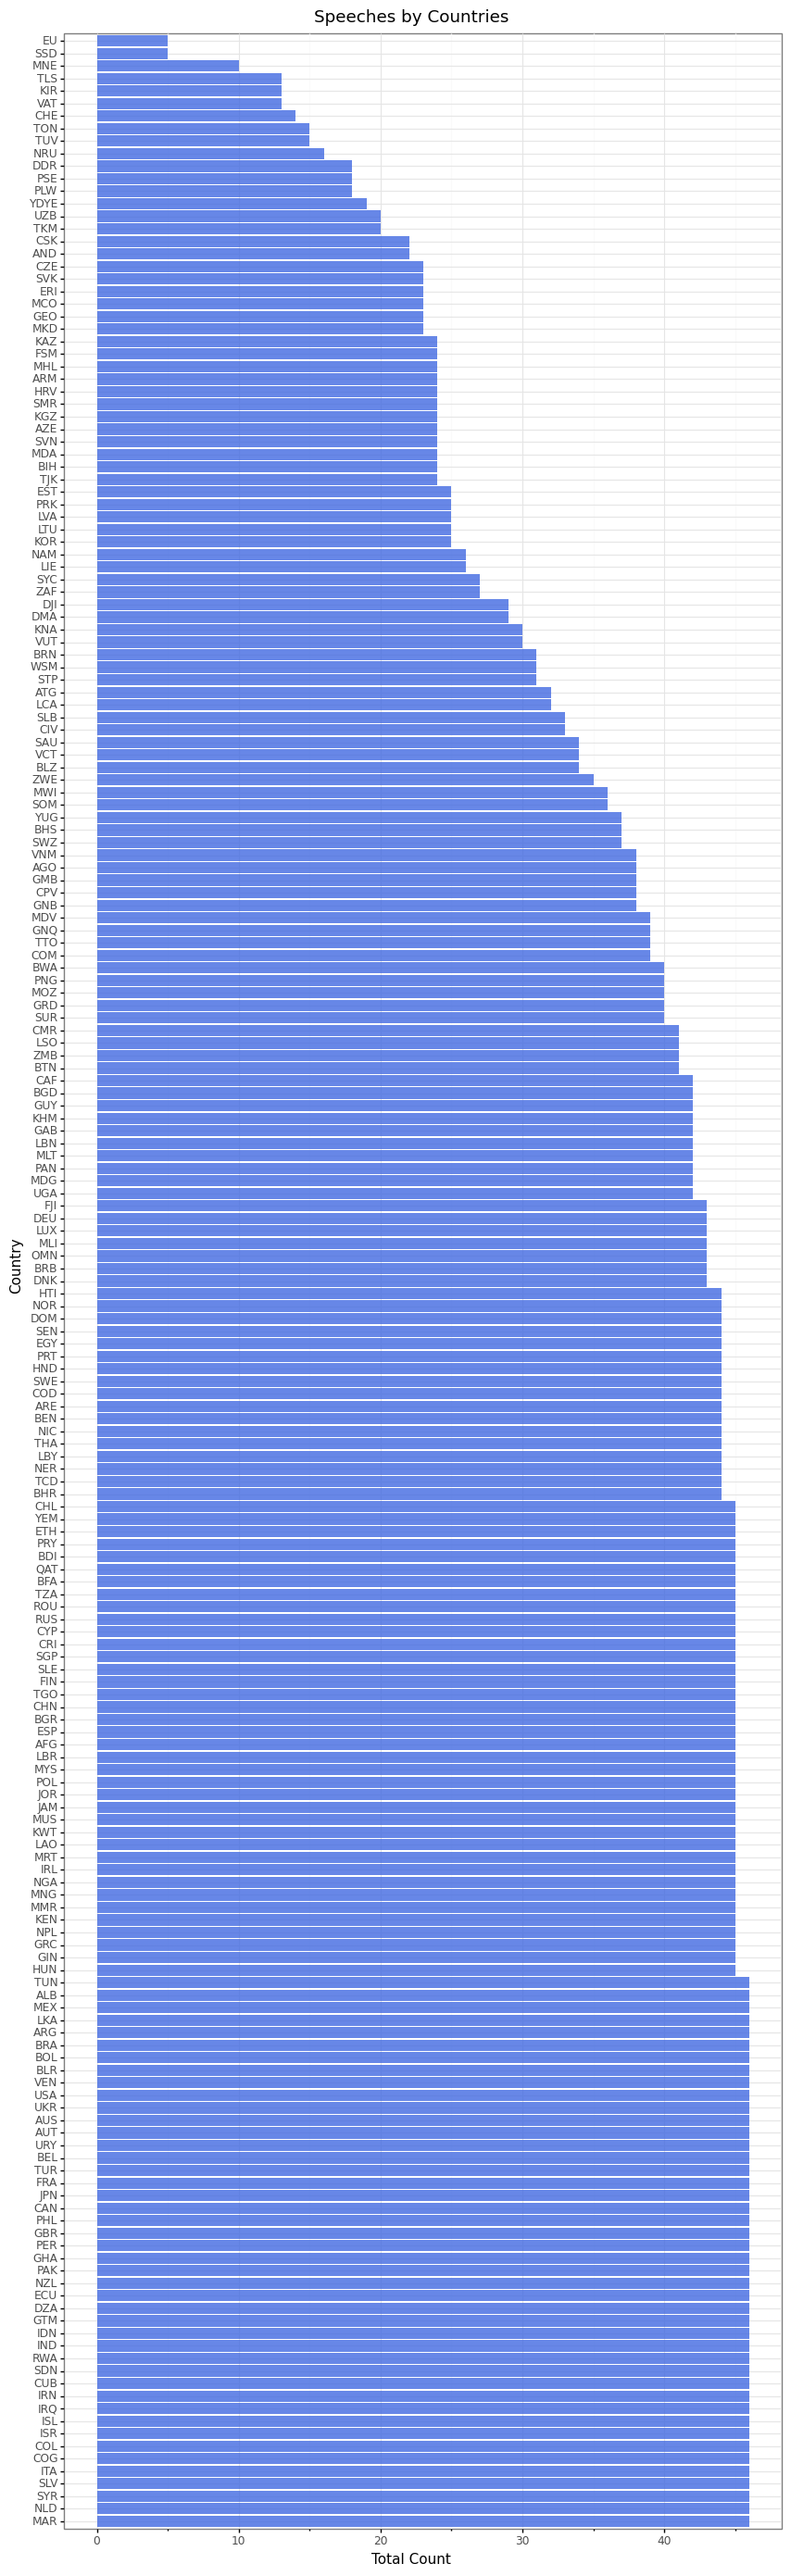

<ggplot: (-9223371910947322144)>

In [7]:
### plot country frequency

# create df for countries
countries = un_speeches[['country','id']]
countries
countries = countries.groupby('country').count().reset_index().rename(columns={'id':"obs"})
countries.sort_values(by=['obs'], inplace=True, ascending=False)

# create list of state names
countries_list = list(countries.country.values)

# plot
plot_countries = (ggplot(countries, aes(x=countries_list,y="obs"))+
geom_bar(stat = "identity",position="dodge",show_legend=False,fill="royalblue",alpha=0.8)+
                  coord_flip() +
labs(x = "Country", y = "Total Count", title="Speeches by Countries")+
 theme_bw()+
 scale_x_discrete(limits = countries_list)+
 theme(figure_size=(10, 35)
))

# save plot
plot_countries.save("plot_countries.png", width=10, height=25, dpi=300)

# view plot
plot_countries

## <center> <font color='royalblue'> Topic Modeling - Full Dataset

In [8]:
# Select only id, speaker, and speech text
df = un_speeches[["id", "speaker", "text"]]

#### Steps:
1. Instantiate vectorizer with parameters: vectorizer
2. Vectorize column of text with fit_transform: X
3. Instantiate LDA model with parameters: lda
4. Fit LDA model to vectorized text: doc_topics

#### 1. Instantiate vectorizer with parameters: vectorizer

In [9]:
# remove punctuation 
df["text"] = df['text'].str.replace("[^\w\s]", '')

# remove numbers
df["text"] = df['text'].str.replace('\d+', '')

# view 
df.head()

warnings.filterwarnings("ignore")

In [10]:
# instantiate vectorizer
vec = CountVectorizer(stop_words="english",
                    lowercase=True,
                    ngram_range=(1, 1), # lower bound,upper bound: 1,1 only unigrams, 1,2 unigrams and bigrams, 2,2 only bigrams, etc...,
                    min_df=5, # ignore rare words (appear in less than 5 documents)
                    max_df=0.8) # ignore common words (appear in more than 80% of documents)

#### 2. Vectorize column of text with fit_transform: X

In [11]:
# create document-term matrix
X = vec.fit_transform(df["text"])

In [12]:
# check: documents, terms
X.shape

(7507, 25352)

In [13]:
print('There are',X.shape[0],'documents, and',X.shape[1],'terms.')

There are 7507 documents, and 25352 terms.


#### 3. Instantiate LDA model with parameters: lda

In [14]:
# instantiate LDA
lda = LatentDirichletAllocation(n_components=4,
                                       random_state=42)

#### 4. Fit LDA model to vectorized text: doc_topics

In [15]:
# fit LDA model to vectorized text
doc_topics = lda.fit_transform(X)

In [16]:
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]} words")

There are 4 topics and 25352 words


### Analysis

#### Extract top words from each topic

In [17]:
# get feature names (vocabulary)
voc = np.array(vec.get_feature_names())

In [18]:
# set number of top words you want
n_words=10

# create lambda function to extra top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [19]:
# use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

In [20]:
# join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

In [21]:
# create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({"top_words": main_topics},
                             index=["Topic_" + str(each) for each in range(lda.n_components)])

In [22]:
# examine top words
main_topics_df

,top_words
Topic_0,social global republic process challenges afri...
Topic_1,peoples africa situation south republic indepe...
Topic_2,africa developing global south small resources...
Topic_3,nuclear weapons europe problems process europe...


In [23]:
# examine top words
list(main_topics_df.top_words.values)

['social global republic process challenges african sustainable reform poverty democratic',
 'peoples africa situation south republic independence relations problems war developing',
 'africa developing global south small resources change today trade african',
 'nuclear weapons europe problems process european conference role global disarmament']

#### Create a document topic matrix from results

In [24]:
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

In [25]:
# create dataframe with term weights and document # and topic # as rows, columns
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                        columns=cols,
                        index=docs)

In [26]:
# Extract most important topics from those values
imp_topic = np.argmax(df_topics.values, axis=1)

In [27]:
# view dataframe
df_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3
Document_0,0.00,1.00,0.00,0.00
Document_1,0.00,0.60,0.00,0.40
Document_2,0.00,0.35,0.15,0.50
Document_3,0.00,0.38,0.00,0.62
Document_4,0.01,0.29,0.00,0.70


In [28]:
# store top topic
df_topics["top_topic"] = imp_topic

In [29]:
# view
df_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,top_topic
Document_0,0.00,1.00,0.00,0.00,1
Document_1,0.00,0.60,0.00,0.40,1
Document_2,0.00,0.35,0.15,0.50,3
Document_3,0.00,0.38,0.00,0.62,3
Document_4,0.01,0.29,0.00,0.70,3


In [30]:
# visualize
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                  dtm=X,
                                  vectorizer=vec,
                                  sort_topics=False)

pyLDAvis.display(lda_viz)

This is a good topic model since there are big non-overlapping bubbles scattered throughout the chart. We can also see that some bubbles are quite far away from each other e.g. 1 and 2 - the longer the distance between bubbles, the more different they are. The bubble representing Topic 2 (i.e. Topic_1 in our dataframe) is the biggest - this means that the percentage of speeches about that topic are the highest in the corpus we have. 

Using the visualization above, I will look at the highest  frequency words in each topic and try to interpret them. 

- Topic 1: Sustainable Development (in developing nations)
- Topic 2: Conflict and Political Unrest in the Global South
- Topic 3: Development Challenges in the Global South
- Topic 4: Nuclear Weapons & Disarmament 

In [31]:
# add labels
main_topics_df['topic_name'] = ['Sustainable Development (in developing nations)',
                                'Conflict and Political Unrest in the Global South',
                                'Development Challenges in the Global South',
                                'Nuclear Weapons & Disarmament']

# view 
main_topics_df

,top_words,topic_name
Topic_0,social global republic process challenges afri...,Sustainable Development (in developing nations)
Topic_1,peoples africa situation south republic indepe...,Conflict and Political Unrest in the Global South
Topic_2,africa developing global south small resources...,Development Challenges in the Global South
Topic_3,nuclear weapons europe problems process europe...,Nuclear Weapons & Disarmament


## <center> <font color='royalblue'> Topic Modeling - USA 

In [32]:
# filter dataset to only include USA
usa_un_speeches = un_speeches[un_speeches.country == 'USA']

In [33]:
print('Dimensionality: This dataset has ',usa_un_speeches.shape[0], ' observations and ',usa_un_speeches.shape[1], ' features.')

Dimensionality: This dataset has  46  observations and  8  features.


In [34]:
# Select only id, speaker, and speech text
df = usa_un_speeches[["id", "speaker", "text"]]

#### Steps:
1. Instantiate vectorizer with parameters: vectorizer
2. Vectorize column of text with fit_transform: X
3. Instantiate LDA model with parameters: lda
4. Fit LDA model to vectorized text: doc_topics

#### 1. Instantiate vectorizer with parameters: vectorizer

In [35]:
warnings.filterwarnings("ignore")


# remove punctuation 
df["text"] = df['text'].str.replace("[^\w\s]", '')

# remove numbers
df["text"] = df['text'].str.replace('\d+', '')

# view 
df.head()

,id,speaker,text
65,65,Mr. YOST,\t It is my privilege to extend to you once ag...
179,179,Mr. ROGERS,Mr President I should like first of all to as...
304,304,Mr. Rogers,During the past few years the world has made r...
424,424,Kissinger,\tI should like to add my congratulations to t...
554,554,Mr. Kissinger,Last year at the previous session th meeting i...


In [36]:
# instantiate vectorizer
vec = CountVectorizer(stop_words="english",
                    lowercase=True,
                    ngram_range=(1, 1), # lower bound,upper bound: 1,1 only unigrams, 1,2 unigrams and bigrams, 2,2 only bigrams, etc...,
                    min_df=5, # ignore rare words (appear in less than 5 documents)
                    max_df=0.8) # ignore common words (appear in more than 80% of documents)

#### 2. Vectorize column of text with fit_transform: X

In [37]:
# create document-term matrix
X = vec.fit_transform(df["text"])

In [38]:
# check: documents, terms
X.shape

(46, 2433)

In [39]:
print('There are',X.shape[0],'documents, and',X.shape[1],'terms.')

There are 46 documents, and 2433 terms.


#### 3. Instantiate LDA model with parameters: lda

In [40]:
# instantiate LDA
lda = LatentDirichletAllocation(n_components=3,
                                       random_state=42)

#### 4. Fit LDA model to vectorized text: doc_topics

In [41]:
# fit LDA model to vectorized text
doc_topics = lda.fit_transform(X)

In [42]:
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]} words")

There are 3 topics and 2433 words


### Analysis

#### Extract top words from each topic

In [43]:
# get feature names (vocabulary)
voc = np.array(vec.get_feature_names())

In [44]:
# set number of top words you want
n_words=10

# create lambda function to extra top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [45]:
# use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

In [46]:
# join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

In [47]:
# create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({"top_words": main_topics},
                             index=["Topic_" + str(each) for each in range(lda.n_components)])

In [48]:
# examine top words
main_topics_df

,top_words
Topic_0,iraq terror regime terrorists iraqi afghanista...
Topic_1,democracy children live century change like le...
Topic_2,soviet arms negotiations developing important ...


In [49]:
# examine top words
list(main_topics_df.top_words.values)

['iraq terror regime terrorists iraqi afghanistan good iraqs terrorist dignity',
 'democracy children live century change like leaders citizens challenges democratic',
 'soviet arms negotiations developing important conference problems organization resolution growth']

#### Create a document topic matrix from results

In [50]:
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

In [51]:
# create dataframe with term weights and document # and topic # as rows, columns
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                        columns=cols,
                        index=docs)

In [52]:
# Extract most important topics from those values
imp_topic = np.argmax(df_topics.values, axis=1)

In [53]:
# view dataframe
df_topics.head()

,Topic_0,Topic_1,Topic_2
Document_0,0.0,0.0,1.0
Document_1,0.0,0.0,1.0
Document_2,0.0,0.0,1.0
Document_3,0.0,0.0,1.0
Document_4,0.0,0.0,1.0


In [54]:
# store top topic
df_topics["top_topic"] = imp_topic

In [55]:
# view
df_topics.head()

,Topic_0,Topic_1,Topic_2,top_topic
Document_0,0.0,0.0,1.0,2
Document_1,0.0,0.0,1.0,2
Document_2,0.0,0.0,1.0,2
Document_3,0.0,0.0,1.0,2
Document_4,0.0,0.0,1.0,2


In [56]:
# visualize
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                  dtm=X,
                                  vectorizer=vec,
                                  sort_topics=False)

pyLDAvis.display(lda_viz)

- Big non-overlapping bubbles scattered throughout the chart (although one bubble is slightly smaller).
- The bubbles are quite far away from each other.
- The bubble representing Topic 3 (i.e. Topic_2 in our dataframe) is the biggest - this means that the percentage of speeches about that topic are the highest in the corpus we have. 

Using the visualization above, I will look at the highest frequency words in each topic and try to interpret them. 

- Topic 1: Terrorism in Iraq & Afghanistan
- Topic 2: Nation Building
- Topic 3: US-Russia Arms Talks

In [57]:
# add labels
main_topics_df['topic_name'] = ['Terrorism in Iraq & Afghanistan',
                                '',
                                'US-Russia Arms Talks']

# view 
main_topics_df

,top_words,topic_name
Topic_0,iraq terror regime terrorists iraqi afghanista...,Terrorism in Iraq & Afghanistan
Topic_1,democracy children live century change like le...,
Topic_2,soviet arms negotiations developing important ...,US-Russia Arms Talks


## <center> <font color='royalblue'> Topic Modeling - USA (before 2001)

In [58]:
# filter dataset to only include USA
usa_un_speeches_pre2001 = un_speeches[(un_speeches.country == 'USA') & (un_speeches.year<2001)]

# view
usa_un_speeches_pre2001.tail()

,id,session,year,country,country_name,speaker,position,text
3910,3910,51,1996,USA,United States,William Jefferson Clinton,President,﻿Three years ago I had the honour\nof being th...
4087,4087,52,1997,USA,United States,Bill Clinton,President,"﻿Five years ago, when I first\naddressed this ..."
4267,4267,53,1998,USA,United States,Bill Clinton,President,Let me begin by thanking the\nAssembly for its...
4448,4448,54,1999,USA,United States,William J. Clinton,President,"Today, we look ahead to the\nnew millennium. A..."
4629,4629,55,2000,USA,United States,Madeleine Korbel Albright,Minister for Foreign Affairs,I am\nhonoured to address the Assembly on beha...


In [59]:
print('Dimensionality: This dataset has ',usa_un_speeches_pre2001.shape[0], ' observations and ',usa_un_speeches_pre2001.shape[1], ' features.')

Dimensionality: This dataset has  31  observations and  8  features.


In [60]:
# Select only id, speaker, and speech text
df = usa_un_speeches_pre2001[["id", "speaker", "text"]]

#### Steps:
1. Instantiate vectorizer with parameters: vectorizer
2. Vectorize column of text with fit_transform: X
3. Instantiate LDA model with parameters: lda
4. Fit LDA model to vectorized text: doc_topics

#### 1. Instantiate vectorizer with parameters: vectorizer

In [61]:
warnings.filterwarnings("ignore")

# remove punctuation 
df["text"] = df['text'].str.replace("[^\w\s]", '')

# remove numbers
df["text"] = df['text'].str.replace('\d+', '')

# view 
df.head()

,id,speaker,text
65,65,Mr. YOST,\t It is my privilege to extend to you once ag...
179,179,Mr. ROGERS,Mr President I should like first of all to as...
304,304,Mr. Rogers,During the past few years the world has made r...
424,424,Kissinger,\tI should like to add my congratulations to t...
554,554,Mr. Kissinger,Last year at the previous session th meeting i...


In [62]:
# instantiate vectorizer
vec = CountVectorizer(stop_words="english",
                    lowercase=True,
                    ngram_range=(1, 1), # lower bound,upper bound: 1,1 only unigrams, 1,2 unigrams and bigrams, 2,2 only bigrams, etc...,
                    min_df=5, # ignore rare words (appear in less than 5 documents)
                    max_df=0.8) # ignore common words (appear in more than 80% of documents)

#### 2. Vectorize column of text with fit_transform: X

In [63]:
# create document-term matrix
X = vec.fit_transform(df["text"])

In [64]:
# check: documents, terms
X.shape

(31, 1800)

In [65]:
print('There are',X.shape[0],'documents, and',X.shape[1],'terms.')

There are 31 documents, and 1800 terms.


#### 3. Instantiate LDA model with parameters: lda

In [66]:
# instantiate LDA
lda = LatentDirichletAllocation(n_components=3,
                                       random_state=42)

#### 4. Fit LDA model to vectorized text: doc_topics

In [67]:
# fit LDA model to vectorized text
doc_topics = lda.fit_transform(X)

In [68]:
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]} words")

There are 3 topics and 1800 words


### Analysis

#### Extract top words from each topic

In [69]:
# get feature names (vocabulary)
voc = np.array(vec.get_feature_names())

In [70]:
# set number of top words you want
n_words=10

# create lambda function to extra top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [71]:
# use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

In [72]:
# join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

In [73]:
# create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({"top_words": main_topics},
                             index=["Topic_" + str(each) for each in range(lda.n_components)])

In [74]:
# examine top words
main_topics_df

,top_words
Topic_0,democracy treaty peacekeeping century children...
Topic_1,negotiations conference parties session proble...
Topic_2,reality problems china republic strength forei...


In [75]:
# examine top words
list(main_topics_df.top_words.values)

['democracy treaty peacekeeping century children said terrorism destruction democratic conflicts',
 'negotiations conference parties session problems energy process peaceful shall settlement',
 'reality problems china republic strength foreign resolution achieve need issues']

#### Create a document topic matrix from results

In [76]:
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

In [77]:
# create dataframe with term weights and document # and topic # as rows, columns
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                        columns=cols,
                        index=docs)

In [78]:
# Extract most important topics from those values
imp_topic = np.argmax(df_topics.values, axis=1)

In [79]:
# view dataframe
df_topics.head()

,Topic_0,Topic_1,Topic_2
Document_0,0.34,0.65,0.00
Document_1,0.00,0.46,0.54
Document_2,0.26,0.67,0.07
Document_3,0.00,0.83,0.17
Document_4,0.00,0.53,0.47


In [80]:
# store top topic
df_topics["top_topic"] = imp_topic

In [81]:
# view
df_topics.head()

,Topic_0,Topic_1,Topic_2,top_topic
Document_0,0.34,0.65,0.00,1
Document_1,0.00,0.46,0.54,2
Document_2,0.26,0.67,0.07,1
Document_3,0.00,0.83,0.17,1
Document_4,0.00,0.53,0.47,1


In [82]:
# visualize
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                  dtm=X,
                                  vectorizer=vec,
                                  sort_topics=False)

pyLDAvis.display(lda_viz)

- Big non-overlapping bubbles scattered throughout the chart (although one bubble is slightly smaller).
- The bubbles are quite far away from each other.
- The bubble representing Topic 1 (i.e. Topic_0 in our dataframe) is the biggest - this means that the percentage of speeches about that topic are the highest in the corpus we have. 

Using the visualization above, I will look at the highest frequency words in each topic and try to interpret them. 

- Topic 1: Peacekeeping & democracy
- Topic 2: Negotiations
- Topic 3: Regional Stability

In [83]:
# add labels
main_topics_df['topic_name'] = ['Peacekeeping & Democracy',
                                '',
                                '']

# view 
main_topics_df

,top_words,topic_name
Topic_0,democracy treaty peacekeeping century children...,Peacekeeping & Democracy
Topic_1,negotiations conference parties session proble...,
Topic_2,reality problems china republic strength forei...,


## <center> <font color='royalblue'> Topic Modeling - USA (2001 onwards)

In [84]:
# filter dataset to only include USA
usa_un_speeches_post2001 = un_speeches[(un_speeches.country == 'USA') & (un_speeches.year >= 2001)]

# view
usa_un_speeches_post2001.head()

,id,session,year,country,country_name,speaker,position,text
4814,4814,56,2001,USA,United States,George W. Bush,President,﻿We meet in a Hall devoted to\npeace; in a cit...
5002,5002,57,2002,USA,United States,Mr. George W. Bush,President,﻿We meet one year and one day\nafter a terrori...
5191,5191,58,2003,USA,United States,George W. Bush,President,"﻿Twenty-four months ago, and\nyesterday in the..."
5382,5382,59,2004,USA,United States,Mr. George W Bush,President,Thank you for the honour of\naddressing the Ge...
5567,5567,60,2005,USA,United States,Condoleezza Rice,Minister for Foregn Affairs,On behalf\nof President Bush and all of the A...


In [85]:
print('Dimensionality: This dataset has ',usa_un_speeches_post2001.shape[0], ' observations and ',usa_un_speeches_post2001.shape[1], ' features.')

Dimensionality: This dataset has  15  observations and  8  features.


In [86]:
# Select only id, speaker, and speech text
df = usa_un_speeches_post2001[["id", "speaker", "text"]]

#### Steps:
1. Instantiate vectorizer with parameters: vectorizer
2. Vectorize column of text with fit_transform: X
3. Instantiate LDA model with parameters: lda
4. Fit LDA model to vectorized text: doc_topics

#### 1. Instantiate vectorizer with parameters: vectorizer

In [87]:
warnings.filterwarnings("ignore")

# remove punctuation 
df["text"] = df['text'].str.replace("[^\w\s]", '')

# remove numbers
df["text"] = df['text'].str.replace('\d+', '')

# view 
df.head()

,id,speaker,text
4814,4814,George W. Bush,We meet in a Hall devoted to\npeace in a city ...
5002,5002,Mr. George W. Bush,We meet one year and one day\nafter a terroris...
5191,5191,George W. Bush,Twentyfour months ago and\nyesterday in the me...
5382,5382,Mr. George W Bush,Thank you for the honour of\naddressing the Ge...
5567,5567,Condoleezza Rice,On behalf\nof President Bush and all of the A...


In [88]:
# instantiate vectorizer
vec = CountVectorizer(stop_words="english",
                    lowercase=True,
                    ngram_range=(1, 1), # lower bound,upper bound: 1,1 only unigrams, 1,2 unigrams and bigrams, 2,2 only bigrams, etc...,
                    min_df=5, # ignore rare words (appear in less than 5 documents)
                    max_df=0.8) # ignore common words (appear in more than 80% of documents)

#### 2. Vectorize column of text with fit_transform: X

In [89]:
# create document-term matrix
X = vec.fit_transform(df["text"])

In [90]:
# check: documents, terms
X.shape

(15, 772)

In [91]:
print('There are',X.shape[0],'documents, and',X.shape[1],'terms.')

There are 15 documents, and 772 terms.


#### 3. Instantiate LDA model with parameters: lda

In [92]:
# instantiate LDA
lda = LatentDirichletAllocation(n_components=3,
                                       random_state=42)

#### 4. Fit LDA model to vectorized text: doc_topics

In [93]:
# fit LDA model to vectorized text
doc_topics = lda.fit_transform(X)

In [94]:
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]} words")

There are 3 topics and 772 words


### Analysis

#### Extract top words from each topic

In [95]:
# get feature names (vocabulary)
voc = np.array(vec.get_feature_names())

In [96]:
# set number of top words you want
n_words=10

# create lambda function to extra top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [97]:
# use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

In [98]:
# join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

In [99]:
# create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({"top_words": main_topics},
                             index=["Topic_" + str(each) for each in range(lda.n_components)])

In [100]:
# examine top words
main_topics_df

,top_words
Topic_0,come israel change challenges palestinians reg...
Topic_1,russia conflict come like order young strong i...
Topic_2,terror terrorists regime iraqi east terrorist ...


In [101]:
# examine top words
list(main_topics_df.top_words.values)

['come israel change challenges palestinians region pursue palestinian responsibility conflict',
 'russia conflict come like order young strong iran different look',
 'terror terrorists regime iraqi east terrorist fight middle liberty iraqs']

#### Create a document topic matrix from results

In [102]:
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

In [103]:
# create dataframe with term weights and document # and topic # as rows, columns
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                        columns=cols,
                        index=docs)

In [104]:
# Extract most important topics from those values
imp_topic = np.argmax(df_topics.values, axis=1)

In [105]:
# view dataframe
df_topics.head()

,Topic_0,Topic_1,Topic_2
Document_0,0.00,0.0,1.00
Document_1,0.00,0.0,1.00
Document_2,0.00,0.0,1.00
Document_3,0.00,0.0,1.00
Document_4,0.54,0.0,0.46


In [106]:
# store top topic
df_topics["top_topic"] = imp_topic

In [107]:
# view
df_topics.head()

,Topic_0,Topic_1,Topic_2,top_topic
Document_0,0.00,0.0,1.00,2
Document_1,0.00,0.0,1.00,2
Document_2,0.00,0.0,1.00,2
Document_3,0.00,0.0,1.00,2
Document_4,0.54,0.0,0.46,0


In [108]:
# visualize
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                  dtm=X,
                                  vectorizer=vec,
                                  sort_topics=False)

pyLDAvis.display(lda_viz)

- Big non-overlapping bubbles scattered throughout the chart (although one bubble is slightly smaller).
- The bubbles are quite far away from each other.
- The bubble representing Topic 1 (i.e. Topic_0 in our dataframe) is the biggest - this means that the percentage of speeches about that topic are the highest in the corpus we have. 

Using the visualization above, I will look at the highest frequency words in each topic and try to interpret them. 

- Topic 1: Israel-Palestine Conflict
- Topic 2: Russia–Syria–Iran–Iraq coalition
- Topic 3: Terrorism in the East

In [109]:
# add labels
main_topics_df['topic_name'] = ['Israel-Palestine Conflict',
                                'Russia–Syria–Iran–Iraq coalition',
                                'Terrorism in the East']

# view 
main_topics_df

,top_words,topic_name
Topic_0,come israel change challenges palestinians reg...,Israel-Palestine Conflict
Topic_1,russia conflict come like order young strong i...,Russia–Syria–Iran–Iraq coalition
Topic_2,terror terrorists regime iraqi east terrorist ...,Terrorism in the East


## <center> <font color='royalblue'> Topic Modeling - UN Security Council Permanent Members

In [110]:
# filter dataset to only permanent UN security council members
country_list = ['USA','RUS','CHN','FRA','GBR']
un_scm_speeches = un_speeches[un_speeches['country'].isin(country_list)]

# view 
un_scm_speeches.head()

,id,session,year,country,country_name,speaker,position,text
17,17,25,1970,FRA,France,Mr. SCHUMANN,NaN,"84.\t Within one month, when we celebrate the..."
18,18,25,1970,GBR,United Kingdom,Sir Alec DOUGLASHOME,NaN,"110.\t Mr. President, I should like first to s..."
65,65,25,1970,USA,United States,Mr. YOST,NaN,1.\t It is my privilege to extend to you once ...
86,86,26,1971,CHN,China,Mr. CHOW,NaN,"1.\t Mr. President, it is my pleasant duty, o..."
103,103,26,1971,FRA,France,Mr. SCHUMANN,NaN,34.\tIt is toward Asia where all the problems ...


In [111]:
print('Dimensionality: This dataset has ',un_scm_speeches.shape[0], ' observations and ',un_scm_speeches.shape[1], ' features.')

Dimensionality: This dataset has  228  observations and  8  features.


In [112]:
# Select only id, speaker, and speech text
df = un_scm_speeches[["id", "speaker", "text"]]

#### Steps:
1. Instantiate vectorizer with parameters: vectorizer
2. Vectorize column of text with fit_transform: X
3. Instantiate LDA model with parameters: lda
4. Fit LDA model to vectorized text: doc_topics

#### 1. Instantiate vectorizer with parameters: vectorizer

In [113]:
warnings.filterwarnings("ignore")

# remove punctuation 
df["text"] = df['text'].str.replace("[^\w\s]", '')

# remove numbers
df["text"] = df['text'].str.replace('\d+', '')

# view 
df.head()

,id,speaker,text
17,17,Mr. SCHUMANN,\t Within one month when we celebrate the twe...
18,18,Sir Alec DOUGLASHOME,\t Mr President I should like first to say how...
65,65,Mr. YOST,\t It is my privilege to extend to you once ag...
86,86,Mr. CHOW,\t Mr President it is my pleasant duty on beh...
103,103,Mr. SCHUMANN,\tIt is toward Asia where all the problems of ...


In [114]:
# instantiate vectorizer
vec = CountVectorizer(stop_words="english",
                    lowercase=True,
                    ngram_range=(1, 1), # lower bound,upper bound: 1,1 only unigrams, 1,2 unigrams and bigrams, 2,2 only bigrams, etc...,
                    min_df=5, # ignore rare words (appear in less than 5 documents)
                    max_df=0.8) # ignore common words (appear in more than 80% of documents)

#### 2. Vectorize column of text with fit_transform: X

In [115]:
# create document-term matrix
X = vec.fit_transform(df["text"])

In [116]:
# check: documents, terms
X.shape

(228, 6454)

In [117]:
print('There are',X.shape[0],'documents, and',X.shape[1],'terms.')

There are 228 documents, and 6454 terms.


#### 3. Instantiate LDA model with parameters: lda

In [118]:
# instantiate LDA
lda = LatentDirichletAllocation(n_components=5,
                                       random_state=42)

#### 4. Fit LDA model to vectorized text: doc_topics

In [119]:
# fit LDA model to vectorized text
doc_topics = lda.fit_transform(X)

In [120]:
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]} words")

There are 5 topics and 6454 words


### Analysis

#### Extract top words from each topic

In [121]:
# get feature names (vocabulary)
voc = np.array(vec.get_feature_names())

In [122]:
# set number of top words you want
n_words=10

# create lambda function to extra top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [123]:
# use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

In [124]:
# join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

In [125]:
# create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({"top_words": main_topics},
                             index=["Topic_" + str(each) for each in range(lda.n_components)])

In [126]:
# examine top words
main_topics_df

,top_words
Topic_0,france china stability regional developing rus...
Topic_1,iraq weapons democracy let freedom help change...
Topic_2,europe european union agreement problems settl...
Topic_3,nuclear south let developing conference proble...
Topic_4,soviet nuclear union weapons relations militar...


In [127]:
# examine top words
list(main_topics_df.top_words.values)

['france china stability regional developing russia nuclear principles respect relations',
 'iraq weapons democracy let freedom help change america believe build',
 'europe european union agreement problems settlement like republic shall conference',
 'nuclear south let developing conference problems negotiations conflict weapons soviet',
 'soviet nuclear union weapons relations military disarmament arms question policy']

#### Create a document topic matrix from results

In [128]:
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

In [129]:
# create dataframe with term weights and document # and topic # as rows, columns
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                        columns=cols,
                        index=docs)

In [130]:
# Extract most important topics from those values
imp_topic = np.argmax(df_topics.values, axis=1)

In [131]:
# view dataframe
df_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
Document_0,0.02,0.14,0.80,0.00,0.03
Document_1,0.00,0.11,0.89,0.00,0.00
Document_2,0.05,0.00,0.31,0.61,0.03
Document_3,0.00,0.17,0.18,0.18,0.46
Document_4,0.07,0.00,0.46,0.36,0.11


In [132]:
# store top topic
df_topics["top_topic"] = imp_topic

In [133]:
# view
df_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,top_topic
Document_0,0.02,0.14,0.80,0.00,0.03,2
Document_1,0.00,0.11,0.89,0.00,0.00,2
Document_2,0.05,0.00,0.31,0.61,0.03,3
Document_3,0.00,0.17,0.18,0.18,0.46,4
Document_4,0.07,0.00,0.46,0.36,0.11,2


In [134]:
# visualize
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                  dtm=X,
                                  vectorizer=vec,
                                  sort_topics=False)

pyLDAvis.display(lda_viz)

- Big non-overlapping bubbles scattered throughout the chart.
- The bubble representing Topic 5 (i.e. Topic_4 in our dataframe) is the biggest - this means that the percentage of speeches about that topic are the highest in the corpus we have. 

Using the visualization above, I will look at the highest frequency words in each topic and try to interpret them. 

- Topic 1: Stable Relations
- Topic 2: Iraq Threat
- Topic 3: European Union
- Topic 4: Nuclear Arms
- Topic 5: Disarmament of Soviet Union

In [135]:
# add labels
main_topics_df['topic_name'] = ['',
                                '',
                                '',
                                '',
                                '']

# view 
main_topics_df

,top_words,topic_name
Topic_0,france china stability regional developing rus...,
Topic_1,iraq weapons democracy let freedom help change...,
Topic_2,europe european union agreement problems settl...,
Topic_3,nuclear south let developing conference proble...,
Topic_4,soviet nuclear union weapons relations militar...,


## <center> <font color='royalblue'> Topic Modeling - PAK

In [136]:
# filter dataset to only include USA
pak_un_speeches = un_speeches[un_speeches.country == 'PAK']

In [137]:
print('Dimensionality: This dataset has ',pak_un_speeches.shape[0], ' observations and ',pak_un_speeches.shape[1], ' features.')

Dimensionality: This dataset has  46  observations and  8  features.


In [138]:
# Select only id, speaker, and speech text
df = pak_un_speeches[["id", "speaker", "text"]]

#### Steps:
1. Instantiate vectorizer with parameters: vectorizer
2. Vectorize column of text with fit_transform: X
3. Instantiate LDA model with parameters: lda
4. Fit LDA model to vectorized text: doc_topics

#### 1. Instantiate vectorizer with parameters: vectorizer

In [139]:
warnings.filterwarnings("ignore")

# remove punctuation 
df["text"] = df['text'].str.replace("[^\w\s]", '')

# remove numbers
df["text"] = df['text'].str.replace('\d+', '')

# view 
df.head()

,id,speaker,text
47,47,Mr. RASHID,\n\t Recognizing Ambassador Hambros long and ...
150,150,Mr. MAHMUD ALI,\tMr President the Pakistan delegation is exce...
275,275,Mr. Roy,Mr President I should like to join those who h...
398,398,Ahmed,\tMr President when my Prime Minister spoke be...
525,525,Mr. Ahmed,Mr President it gives my delegation great plea...


In [140]:
# instantiate vectorizer
vec = CountVectorizer(stop_words="english",
                    lowercase=True,
                    ngram_range=(1, 1), # lower bound,upper bound: 1,1 only unigrams, 1,2 unigrams and bigrams, 2,2 only bigrams, etc...,
                    min_df=5, # ignore rare words (appear in less than 5 documents)
                    max_df=0.8) # ignore common words (appear in more than 80% of documents)

#### 2. Vectorize column of text with fit_transform: X

In [141]:
# create document-term matrix
X = vec.fit_transform(df["text"])

In [142]:
# check: documents, terms
X.shape

(46, 2310)

In [143]:
print('There are',X.shape[0],'documents, and',X.shape[1],'terms.')

There are 46 documents, and 2310 terms.


#### 3. Instantiate LDA model with parameters: lda

In [144]:
# instantiate LDA
lda = LatentDirichletAllocation(n_components=3,
                                       random_state=42)

#### 4. Fit LDA model to vectorized text: doc_topics

In [145]:
# fit LDA model to vectorized text
doc_topics = lda.fit_transform(X)

In [146]:
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]} words")

There are 3 topics and 2310 words


### Analysis

#### Extract top words from each topic

In [147]:
# get feature names (vocabulary)
voc = np.array(vec.get_feature_names())

In [148]:
# set number of top words you want
n_words=10

# create lambda function to extra top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [149]:
# use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

In [150]:
# join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

In [151]:
# create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({"top_words": main_topics},
                             index=["Topic_" + str(each) for each in range(lda.n_components)])

In [152]:
# examine top words
main_topics_df

,top_words
Topic_0,disarmament settlement conference agreement af...
Topic_1,islamic situation foreign africa islam problem...
Topic_2,terrorism kashmiri afghan dialogue democracy i...


In [153]:
# examine top words
list(main_topics_df.top_words.values)

['disarmament settlement conference agreement africa negotiations powers independence order special',
 'islamic situation foreign africa islam problem problems indian race independence',
 'terrorism kashmiri afghan dialogue democracy indian pakistans prosperity social democratic']

#### Create a document topic matrix from results

In [154]:
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

In [155]:
# create dataframe with term weights and document # and topic # as rows, columns
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                        columns=cols,
                        index=docs)

In [156]:
# Extract most important topics from those values
imp_topic = np.argmax(df_topics.values, axis=1)

In [157]:
# view dataframe
df_topics.head()

,Topic_0,Topic_1,Topic_2
Document_0,0.19,0.81,0.00
Document_1,0.00,1.00,0.00
Document_2,0.96,0.00,0.03
Document_3,1.00,0.00,0.00
Document_4,1.00,0.00,0.00


In [158]:
# store top topic
df_topics["top_topic"] = imp_topic

In [159]:
# view
df_topics.head()

,Topic_0,Topic_1,Topic_2,top_topic
Document_0,0.19,0.81,0.00,1
Document_1,0.00,1.00,0.00,1
Document_2,0.96,0.00,0.03,0
Document_3,1.00,0.00,0.00,0
Document_4,1.00,0.00,0.00,0


### Visualizations

In [160]:
# visualize
lda_viz = pyLDAvis.sklearn.prepare(lda_model=lda,
                                  dtm=X,
                                  vectorizer=vec,
                                  sort_topics=False)

pyLDAvis.display(lda_viz)

- Big non-overlapping bubbles scattered throughout the chart (although one bubble is slightly smaller).
- The bubbles are quite far away from each other.
- The bubble representing Topic 1 (i.e. Topic_0 in our dataframe) is the biggest - this means that the percentage of speeches about that topic are the highest in the corpus we have. 

Using the visualization above, I will look at the highest frequency words in each topic and try to interpret them. 

- Topic 1: Disarmament Negotiations 
- Topic 2: Islam
- Topic 3: Terrorism

In [161]:
# add labels
main_topics_df['topic_name'] = ['Disarmament Negotiations',
                                'Islam',
                                'Terrorism']

# view 
main_topics_df

,top_words,topic_name
Topic_0,disarmament settlement conference agreement af...,Disarmament Negotiations
Topic_1,islamic situation foreign africa islam problem...,Islam
Topic_2,terrorism kashmiri afghan dialogue democracy i...,Terrorism


# <center> Supplemental - Using Gensim Corpus

## <center> <font color='royalblue'> Topic Modeling - Full Dataset

In [162]:
# view full dataset
un_speeches.head()

,id,session,year,country,country_name,speaker,position,text
0,0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


In [163]:
warnings.filterwarnings("ignore")

# remove punctuation
un_speeches["text"] = un_speeches['text'].str.replace("[^\w\s]", '')

In [164]:
# enforce uniform lower casing
un_speeches["text"] = un_speeches['text'].str.lower()

In [165]:
# tokenize text column
un_speeches["tokenized"] = un_speeches["text"].apply(word_tokenize)

In [166]:
# remove stopwords
sw = stopwords.words("english")
un_speeches["tokenized"] = un_speeches['tokenized'].apply(lambda x: [each for each in x if each not in sw])

In [167]:
# view dataframe
un_speeches.head()

,id,session,year,country,country_name,speaker,position,text,tokenized
0,0,25,1970,ALB,Albania,Mr. NAS,NaN,33 may i first convey to our president the con...,"[33, may, first, convey, president, congratula..."
1,1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177\t it is a fortunate coincidence that prec...,"[177, fortunate, coincidence, precisely, time,..."
2,2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100\t it is a pleasure for me to extend to yo...,"[100, pleasure, extend, mr, president, warmest..."
3,3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155\t may i begin by expressing to ambassador...,"[155, may, begin, expressing, ambassador, hamb..."
4,4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,176 no doubt each of us before coming up to th...,"[176, doubt, us, coming, rostrum, wonders, use..."


In [168]:
# create gensim dictionary with tokens and ids
dictionary = Dictionary(un_speeches["tokenized"])

In [169]:
# create gensim corpus, uses bag of words with token ids and tf
# gensim_corpus: Returned in gensim_corpus: series of tuples with (token_id, token_freq_in_doc)
gensim_corpus = [dictionary.doc2bow(doc) for doc in un_speeches["tokenized"]]

In [170]:
# fit model - LDA
ldamodel = LdaModel(corpus=gensim_corpus,
                   num_topics = 3,
                   id2word=dictionary)

In [171]:
# view the top 5 words in topic 1 
print(f"Top 5 words in topic 1:")
ldamodel.top_topics(gensim_corpus, topn=5)[0][0]

Top 5 words in topic 1:


[(0.012498764, 'nations'),
 (0.012316881, 'united'),
 (0.0118736485, 'international'),
 (0.008249565, 'world'),
 (0.008233478, 'countries')]

In [172]:
# view the top 5 words in topic 2 
print(f"Top 5 words in topic 1:")
ldamodel.top_topics(gensim_corpus, topn=5)[1][0]

Top 5 words in topic 1:


[(0.01291267, 'nations'),
 (0.011574322, 'united'),
 (0.008377253, 'international'),
 (0.008142526, 'world'),
 (0.0077024223, 'development')]

In [173]:
# view the top 5 words in topic 3 
print(f"Top 5 words in topic 1:")
ldamodel.top_topics(gensim_corpus, topn=5)[2][0]

Top 5 words in topic 1:


[(0.011646468, 'international'),
 (0.009744441, 'united'),
 (0.009006834, 'nations'),
 (0.008618362, 'development'),
 (0.005991032, 'peace')]

#### Model evaluation

In [174]:
# perlexity and coherence
perp = ldamodel.log_perplexity(gensim_corpus)

# Calculate coherence
coh = CoherenceModel(model=ldamodel,
                     texts=un_speeches["tokenized"],
                    corpus=gensim_corpus,
                    coherence="c_v").get_coherence()

# view
print(f"Perplexity: {perp}\nCoherence: {coh}")

Perplexity: -8.077123617472337
Coherence: 0.2690113712635039


#### Analysis

In [175]:
pyLDAvis.enable_notebook()
vis = gensim_pyvis.prepare(ldamodel,
                       gensim_corpus,
                       dictionary)
pyLDAvis.display(vis)

## <center> <font color='royalblue'> Topic Modeling - USA 

In [176]:
# filter dataset to only include USA
usa_un_speeches = un_speeches[un_speeches.country == 'USA']

In [177]:
print('Dimensionality: This dataset has ',usa_un_speeches.shape[0], ' observations and ',usa_un_speeches.shape[1], ' features.')

Dimensionality: This dataset has  46  observations and  9  features.


In [178]:
warnings.filterwarnings("ignore")

# remove punctuation
usa_un_speeches["text"] = usa_un_speeches['text'].str.replace("[^\w\s]", '')

In [179]:
# enforce uniform lower casing
usa_un_speeches["text"] = usa_un_speeches['text'].str.lower()

In [180]:
# tokenize text column
usa_un_speeches["tokenized"] = usa_un_speeches["text"].apply(word_tokenize)

In [181]:
# remove stopwords
sw = stopwords.words("english")
usa_un_speeches["tokenized"] = usa_un_speeches['tokenized'].apply(lambda x: [each for each in x if each not in sw])

In [182]:
# view dataframe
usa_un_speeches.head()

,id,session,year,country,country_name,speaker,position,text,tokenized
65,65,25,1970,USA,United States,Mr. YOST,NaN,1\t it is my privilege to extend to you once a...,"[1, privilege, extend, warm, congratulations, ..."
179,179,26,1971,USA,United States,Mr. ROGERS,NaN,mr president i should like first of all to as...,"[mr, president, like, first, associate, previo..."
304,304,27,1972,USA,United States,Mr. Rogers,NaN,during the past few years the world has made r...,"[past, years, world, made, remarkable, advance..."
424,424,28,1973,USA,United States,Kissinger,NaN,35\ti should like to add my congratulations to...,"[35, like, add, congratulations, well, express..."
554,554,29,1974,USA,United States,Mr. Kissinger,NaN,last year at the previous session 2124th meeti...,"[last, year, previous, session, 2124th, meetin..."


In [183]:
# create gensim dictionary with tokens and ids
dictionary = Dictionary(usa_un_speeches["tokenized"])

In [184]:
# create gensim corpus, uses bag of words with token ids and tf
# gensim_corpus: Returned in gensim_corpus: series of tuples with (token_id, token_freq_in_doc)
gensim_corpus = [dictionary.doc2bow(doc) for doc in usa_un_speeches["tokenized"]]

In [185]:
# fit model - LDA
ldamodel = LdaModel(corpus=gensim_corpus,
                   num_topics = 3,
                   id2word=dictionary)

In [186]:
# view the top 5 words in topic 1 
print(f"Top 5 words in topic 1:")
ldamodel.top_topics(gensim_corpus, topn=5)[0][0]

Top 5 words in topic 1:


[(0.01485841, 'nations'),
 (0.01400524, 'united'),
 (0.00878821, 'states'),
 (0.008483238, 'world'),
 (0.006210164, 'must')]

In [187]:
# view the top 5 words in topic 2
print(f"Top 5 words in topic 2:")
ldamodel.top_topics(gensim_corpus, topn=5)[1][0]

Top 5 words in topic 2:


[(0.014583317, 'united'),
 (0.011847617, 'nations'),
 (0.007447906, 'must'),
 (0.0068933354, 'world'),
 (0.0058615417, 'states')]

In [188]:
# view the top 5 words in topic 3
print(f"Top 5 words in topic 3:")
ldamodel.top_topics(gensim_corpus, topn=5)[2][0]

Top 5 words in topic 3:


[(0.015452854, 'nations'),
 (0.015224995, 'united'),
 (0.010149671, 'world'),
 (0.008928082, 'states'),
 (0.0087628625, 'peace')]

#### Model evaluation

In [189]:
# perlexity and coherence
perp = ldamodel.log_perplexity(gensim_corpus)

# Calculate coherence
coh = CoherenceModel(model=ldamodel,
                     texts=usa_un_speeches["tokenized"],
                    corpus=gensim_corpus,
                    coherence="c_v").get_coherence()

# view
print(f"Perplexity: {perp}\nCoherence: {coh}")

Perplexity: -8.125292143908132
Coherence: 0.2562649919937329


#### Analysis

In [190]:
pyLDAvis.enable_notebook()
vis = gensim_pyvis.prepare(ldamodel,
                       gensim_corpus,
                       dictionary)
pyLDAvis.display(vis)